# _Dataset cleaning : Ratings_

## . Import Libraries

In [157]:
# Libraries neeeded to work on the data
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pylab as pl
import scipy.stats as stats
import seaborn as sns
import pickle

from sklearn.preprocessing import OneHotEncoder, Normalizer, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [59]:
import warnings
warnings.filterwarnings('ignore')


# Dataset has 271361 rows, jupyter notebook is crashing 
#if I don't limit the number of rows displayed below.
pd.set_option('display.max_columns', 1000) 
pd.set_option('display.max_rows', 1000)
pd.options.display.max_columns = 1000

##  . _Import Data_

In [73]:
books = pd.read_csv('books_final.csv')

In [61]:
ratings = pd.read_csv('ratings_final.csv')

In [130]:
users = pd.read_csv('users_final.csv')

##  . _Data Exploring_

Explore and check the dataset, it is necessary to know your dataset before starting cleaning or 
dropping information.

In [63]:
books.shape

(271359, 6)

In [64]:
ratings.shape

(1149780, 4)

In [65]:
users.shape

(278858, 7)

Type of data:

In [66]:
ratings['book_rating'].unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2], dtype=int64)

## _Pre-processing_

Ratings dataset will have n_users*n_books entries if every user rated every item,this shows that the dataset is very sparse Ratings dataset will have users * books number of records

In [68]:
n_users = users.shape[0]
n_books = books.shape[0]
n_users * n_books

75670628022

In [70]:
ratings.head(10)

,Unnamed: 0,user_id,isbn,book_rating
0,0,276725,034545104X,0
1,1,276726,0155061224,5
2,2,276727,0446520802,0
3,3,276729,052165615X,3
4,4,276729,0521795028,6
5,5,276733,2080674722,0
6,6,276736,3257224281,8
7,7,276737,0600570967,6
8,8,276744,038550120X,7
9,9,276745,342310538,10


In [71]:
ratings['book_rating'].unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2], dtype=int64)

Ratings dataset should have only books which exist in our books dataset, unless new books are added to the dataset.

In [74]:
ratings_new = ratings[ratings.isbn.isin(books.isbn)]

ratings.shape,ratings_new.shape

((1149780, 4), (1031135, 4))

We can see that many rows are having book isbn not part of books dataset got dropped off.

Ratings dataset should have ratings from users which exist in users dataset, unless new users are added to users dataset

In [76]:
ratings = ratings[ratings['user_id'].isin(users['user_id'])]

print(ratings.shape)
print(ratings_new.shape)

(n_users), (n_books)

(1149780, 4)
(1031135, 4)


(278858, 271359)

There is no new users added, so we will use the dataset above ratings_new (1031136, 3)

### _Implicit and explict ratings_

As shown bellow we have a lot of zero rating which are no use for our analysis

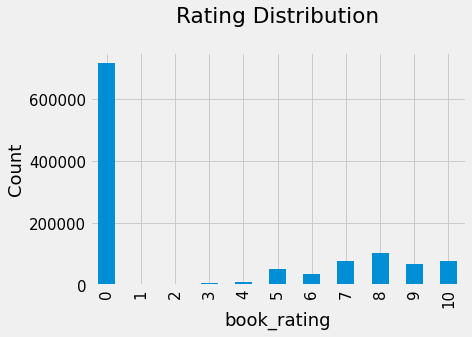

In [115]:
plt.rc("font", size=15)
ratings.book_rating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('book_rating')
plt.ylabel('Count')
plt.show()

Segragating implicit and explict ratings datasets : 

   - explicit ratings is represented by 1–10
   - implicit ratings is represented by 0 
 (Removing the zero.)

In [77]:
ratings_explicit = ratings_new[ratings_new.book_rating != 0]
ratings_implicit = ratings_new[ratings_new.book_rating == 0]

Checking shapes :

In [78]:
print(ratings_new.shape)
print(ratings_explicit.shape)
print(ratings_implicit.shape)

(1031135, 4)
(383841, 4)
(647294, 4)


Plotting count of book_rating :

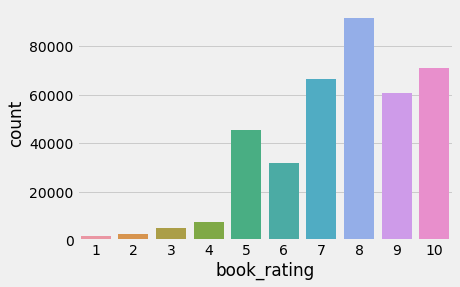

In [79]:
sns.countplot(data=ratings_explicit , x='book_rating')
plt.show();

it can be seen that higher ratings are more common amongst users and rating 8 has been rated highest number of times

### _Sparsity :_

Some users have rated books which are not part of original books dataset. Sparsity of the dataset can be calculated as below:

In [80]:
sparsity=1.0-len(ratings_new)/float(n_users*n_books)
print ('Sparsity level of book dataset is ' + str(sparsity*100) + ' %')

Sparsity level of book dataset is 99.99863733785888 %


## _Recommendation systems_

What actually is Recommendation System
A recommendation engine is a class of machine learning which offers relevant suggestions to the customer.  Before the recommendation system, the major tendency to buy was to take a suggestion from friends. But Now Google knows what news you will read, Youtube knows what type of videos you will watch based on your search history, watch history, or purchase history.

A recommendation system helps an organization to create loyal customers and build trust by them desired products and services for which they came on your site. The recommendation system today are so powerful that they can handle the new customer too who has visited the site for the first time. They recommend the products which are currently trending or highly rated and they can also recommend the products which bring maximum profit to the company.

### _Types Of Recommendation System :_

A recommendation system is usually built using techniques which are content-based filtering, collaborative filtering, and a combination of both.

   - Simple recommenders: 

Generalized recommendations to every user, based on book popularity and/or genre. The basic idea behind this system is that books that are more popular and critically acclaimed will have a higher probability of being liked by the average audience.

   - Content-Based Filtering :

The algorithm recommends a product that is similar to those which used as watched. In simple words, In this algorithm, we try to find item which look alike (similar ages, categories ...).

 it only looked at the similarity between the content and does not focus on the person who is reading it. this system recommends the book which has the highest score based on past preferences.


   - Collaborative-based Filtering :

Collaborative based filtering recommender systems are based on past interactions of users and target items.  In simple words here, we try to search for the look-alike customers and offer products based on what his or her lookalike has chosen. 

Exemple : Youtube 


   - Hybrid Filtering Method :

It is basically a combination of both of the above methods. It is a too complex model which recommends product based on your history as well as based on similar users.

Exemple : Facebook, Linkedin.


Book Recommendation System:
A book recommendation system is a type of recommendation system where we have to recommend similar books to the reader based on his interest. The books recommendation system is used by online websites which provide ebooks like google play books, open library, good Read’s, etc.


https://www.analyticsvidhya.com/blog/2021/06/build-book-recommendation-system-unsupervised-learning-project/

### _Simple Popularity based Recommendation System_

#### _Top 10 Rated books_

In [82]:
ratings_count = pd.DataFrame(ratings_explicit.groupby(['isbn'])['book_rating'].sum())
top10 = ratings_count.sort_values('book_rating', ascending = False).head(10)
print ("Top 10 books:")
top10.merge(data, left_index = True, right_on = 'isbn')

Top 10 books:


,book_rating_x,Unnamed: 0,isbn,book_title,book_author,year_of_publication,publisher,user_id,book_rating_y,age,city,region,country
221,5787,221,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",11676,5,34,NaN,n/a,n/a
11587,5787,11587,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",96054,10,29,ottawa,ontario,canada
11904,5787,11904,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",177458,0,29,ottawa,ontario,canada
13561,5787,13561,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",263325,0,27,fredericton,new brunswick,canada
13829,5787,13829,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",110912,0,36,milpitas,california,usa
...,...,...,...,...,...,...,...,...,...,...,...,...,...
632322,2179,632322,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star,272982,6,39,columbus,ohio,usa
632334,2179,632334,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star,273470,0,57,santa monica,california,usa
632354,2179,632354,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star,275383,9,43,denver,colorado,usa
632395,2179,632395,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star,275610,0,37,new orleans,louisiana,usa


In [160]:
rating_count = pd.DataFrame(ratings.groupby('isbn')['book_rating'].count())
rating_count.sort_values('book_rating', ascending=False).head(5)

,book_rating
isbn,
0971880107,2502
0316666343,1295
0385504209,883
0060928336,732
0312195516,723


The book with ISBN "0971880107" received the most ratings. Let's find out which books are in the top 5.

In [161]:
top_rated_books = pd.DataFrame(['0971880107', '0316666343', '0385504209', '0060928336', '0312195516'], index=np.arange(5), columns = ['isbn'])
top_rated_books_5 = pd.merge(top_rated_books, books, on='isbn')
top_rated_books_5

,isbn,Unnamed: 0,book_title,book_author,year_of_publication,publisher
0,0971880107,26,Wild Animus,Rich Shapero,2004,Too Far
1,0316666343,408,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
2,0385504209,748,The Da Vinci Code,Dan Brown,2003,Doubleday
3,0060928336,1105,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial
4,0312195516,522,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA


### _Collaborative Filtering based Recommendation System/Recommendations based on correlations_

In [162]:
average_rating = pd.DataFrame(ratings.groupby('isbn')['book_rating'].mean())
average_rating['rating_count'] = pd.DataFrame(ratings.groupby('isbn')['book_rating'].count())
average_rating.sort_values('rating_count', ascending=False).head()

,book_rating,rating_count
isbn,,
0971880107,1.020,2502
0316666343,4.469,1295
0385504209,4.652,883
0060928336,3.448,732
0312195516,4.335,723


For more accurate results only consider users who have rated atleast 100 books

In [163]:
counts1 = ratings_explicit['user_id'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['user_id'].isin(counts1[counts1 >= 200].index)]
counts = ratings_explicit['book_rating'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['book_rating'].isin(counts[counts >= 100].index)]

In [164]:
ratings_explicit.shape

(58174, 4)

In [165]:
ratings_matrix = ratings_explicit.pivot(index='user_id', columns='isbn', values='book_rating').fillna(0)
user_id = ratings_matrix.index
isbn = ratings_matrix.columns
print(ratings_matrix.shape)
ratings_matrix.head()

(118, 44306)


isbn,0000913154,0001046438,000104687X,0001047213,0001047973,0001048082,0001053736,0001053744,0001056107,0001845039,0001944711,0001952803,0001953877,0002005018,0002118580,0002158973,0002163713,0002176181,0002176432,0002181924,0002184974,0002190915,000223257X,0002233509,0002239183,0002241358,000225056X,0002250810,0002251485,0002251760,0002252376,0002253372,0002255014,0002255081,0002258560,000225929X,0002316196,0002325780,0002550563,0002551675,0002553384,0002554119,0002554283,0002558122,0002558661,0002726874,0004125576,000433549X,0004356373,0004588010,0004588177,0004701674,0004702816,0004704754,0004704932,0004708105,0004720164,0004722124,0004723708,0004725042,000611962X,0006131409,0006143199,0006156487,0006157629,0006171982,0006174841,0006175317,0006176747,0006177492,0006178316,0006279945,0006363121,0006366023,0006370829,0006371248,0006379702,0006380964,0006384722,0006384854,000647425X,000648302X,0006485200,0006485936,0006492347,000649840X,0006498493,0006512062,0006512143,0006512208,0006512801,0006531407,0006543545,0006544959,0006546684,0006547486,0006547613,0006547834,0006548180,0006548539,0006548830,0006550789,0006550924,0006551076,0006552390,0006729835,000673765X,0006742939,0006742947,0006928323,0007100108,0007100930,0007102216,000710331X,0007103352,0007103360,0007105150,0007105665,0007106572,000710698X,0007107900,0007110200,0007110227,0007110928,0007114788,0007116993,0007117507,0007118465,000712032X,0007122039,0007122861,0007127936,0007139411,0007144172,0007144350,0007154607,0007154615,0020016700,0020088248,0020093616,0020103514,002011690X,0020125305,0020125607,0020188706,0020198817,0020198906,0020199600,0020199856,0020209851,0020223722,0020225601,0020248717,0020259913,002026478X,0020264852,0020280505,002028361X,0020296703,0020296800,0020299605,0020332858,002036041X,0020383142,002040400X,0020407009,0020413904,0020419805,0020426801,0020427018,0020427107,0020427115,0020427751,0020427859,0020429819,0020434804,0020434901,0020442009,0020442203,0020442300,0020442408,0020442602,0020446500,0020449313,0020486200,0020518501,0020518609,0020518706,0020519001,0020545304,0020633505,0020648200,0020698461,0020780605,0020794207,0020795904,0020811608,0020811853,0020819706,0020820445,0020838506,0020868308,0020868901,0020869002,002089130X,0023018909,0023060956,002325291X,0023381205,0023401354,0023582901,0023635703,0023728213,0023886854,0024096903,0024103411,002411510X,002411510x,0024181900,0024182001,0024206202,0024967602,0025074857,002517990X,0025226207,002542730X,0025439472,0025729853,0025845403,0025876007,0026128101,0026205408,0026217457,0026258102,0026305909,0026638959,0026888130,0026890712,0027110400,0027110559,002711080X,0027111008,0027118401,0027136701,0027136809,0027147509,0027153800,0027345459,0027359409,0027426459,0027434850,0027582000,0027614204,0027617319,0027627403,0027701301,0027778800,0027824500,0027826902,0027859002,0027887901,0027912906,0027916405,0028025008,0028603702,0028603923,0028603958,0028604032,0028604105,0028604199,0028604202,0028604458,0028604954,0028608127,0028608364,0028610105,0028610407,0028612787,0028613228,0028614496,0028614518,0028617274,0028617452,0028618874,0028619471,0028621573,0028621697,0028623908,0028624491,0028625757,0028626354,0028628594,0028629019,0028630106,0028630912,0028631188,0028636279,0028639456,0028640071,0028641701,0028641736,0028642082,002864896X,0028653343,0028702514,0028740173,0028981294,002898238X,0029021006,0029064414,0029079705,0029166764,0029227909,0029250617,0029298652,0029353017,0029356504,0029638607,0029640407,0029690803,0029692407,0029693306,0030000726,0030000920,0030009995,003001512X,0030018897,003003678x,003004068X,003005608X,0030056276,0030056292,0030061091,0030085373,003008539X,0030095344,0030115078,0030127440,0030138663,0030149010,0030172217,0030206812,0030226767,0030230667,0030384427,0030423910,0030448514,0030448565,0030448611,0030452457,0030474868,0030477166,0030491266,0030491762,0030491819,003049186X,003049186x,0030491916,0030491967,0030547032,003055487X,0030560632,0030567769,00

Since NaNs cannot be handled by training algorithm, replacing these by 0, which indicates absence of ratings

In [167]:
bones_ratings = ratings_matrix['0316666343']
similar_to_bones = ratings_matrix.corrwith(bones_ratings)
corr_bones = pd.DataFrame(similar_to_bones, columns=['pearsonR'])
corr_bones.dropna(inplace=True)
corr_summary = corr_bones.join(average_rating['rating_count'])
corr_summary[corr_summary['rating_count']>=300].sort_values('pearsonR', ascending=False).head(10)

,pearsonR,rating_count
isbn,,
0316666343,1.000,1295
0312278586,0.379,474
0375726403,0.359,321
0345361792,0.338,412
0156027321,0.327,462
0060930535,0.301,494
0316769487,0.290,403
0375700757,0.277,311
0060934417,0.276,350


In [168]:
books_corr_to_bones = pd.DataFrame(['0312291639', '0316601950', '0446610038', '0446672211', '0385265700', '0345342968', '0060930535', '0375707972', '0684872153'], 
                                  index=np.arange(9), columns=['isbn'])
corr_books = pd.merge(books_corr_to_bones, books, on='isbn')
corr_books

,isbn,Unnamed: 0,book_title,book_author,year_of_publication,publisher
0,0312291639,2849,The Nanny Diaries: A Novel,Emma McLaughlin,2003,St. Martin's Griffin
1,0316601950,4824,The Pilot's Wife : A Novel,Anita Shreve,1999,Back Bay Books
2,0446610038,1863,1st to Die: A Novel,James Patterson,2002,Warner Vision
3,0446672211,706,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998,Warner Books
4,0385265700,2536,The Book of Ruth (Oprah's Book Club (Paperback)),Jane Hamilton,1990,Anchor
5,0345342968,2230,Fahrenheit 451,RAY BRADBURY,1987,Del Rey
6,0060930535,1373,The Poisonwood Bible: A Novel,Barbara Kingsolver,1999,Perennial
7,0375707972,1702,The Reader,Bernhard Schlink,1999,Vintage Books USA
8,0684872153,4578,Angela's Ashes (MMP) : A Memoir,Frank McCourt,1999,Scribner


Generate the predicted ratings using SVD with number of singular values to be 50

In [89]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(ratings_matrix, k = 50)

In [90]:
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = ratings_matrix.columns)

In [91]:
preds_df.head()

isbn,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,0001056107,0001845039,0001935968,0001944711,0001952803,0001953877,0002000547,0002005018,0002005050,0002005557,0002006588,0002115328,0002116286,0002118580,0002154900,0002158973,0002163713,0002176181,0002176432,0002179695,0002181924,0002184974,0002190915,0002197154,0002223929,0002228394,000223257X,0002233509,0002239183,0002240114,0002241358,0002244098,0002245728,000225056X,0002250810,0002251000,0002251485,0002251760,0002252341,0002252376,0002253372,0002255014,0002255081,0002258560,000225929X,0002259877,0002316196,0002317141,0002325780,0002550563,0002551195,0002551675,0002553384,0002554119,0002554283,0002555565,0002558122,0002558661,0002712172,0002726874,0003300277,0004125576,0004133439,0004334787,000433549X,0004356373,0004588010,0004588177,0004701674,0004702816,0004704746,0004704754,0004704932,0004708105,0004709721,000470973X,0004720164,0004720695,0004722124,0004723708,0004724097,0004725042,000611962X,0006131409,0006143199,0006156487,0006157629,0006166598,0006171982,0006174841,0006175317,0006176747,0006176992,0006177492,0006178316,0006271197,0006279945,0006280803,0006363113,0006363121,0006365744,0006366023,0006370039,0006370829,0006371248,0006372899,0006375952,0006379702,0006380263,0006380921,0006380964,0006383777,0006384684,0006384722,0006384854,0006385370,0006385648,0006386369,0006472648,000647425X,0006480608,000648302X,0006485200,0006485936,0006490603,0006492126,0006492347,0006497993,000649840X,0006498493,000651202X,000651202x,0006512062,0006512143,0006512208,0006512801,0006514952,0006531407,0006542808,0006543545,0006544959,0006546684,0006547486,0006547613,0006547753,0006547834,0006548180,0006548539,0006548830,0006550061,0006550576,0006550789,0006550924,0006551076,0006551971,0006552390,0006726143,0006729835,000673765X,0006742939,0006742947,0006754864,0006928323,0006940889,0007100108,0007100930,0007102216,000710331X,0007103352,0007103360,0007103867,0007105150,0007105665,0007106572,000710698X,0007107900,0007110200,0007110227,0007110928,0007114788,0007116993,000711737X,0007117507,0007118465,0007119070,0007119860,000712032X,0007122039,0007122861,0007127936,0007128568,0007128576,0007139411,0007141076,0007144172,0007144350,000715111X,0007154607,0007154615,000716226X,0007164076,0007176023,000764065X,0020009607,0020016700,0020088248,0020093616,0020103514,002011690X,0020125305,0020125607,0020154402,0020155506,0020182104,0020188706,0020197802,0020198817,0020198841,0020198906,0020199031,0020199600,0020199856,0020209851,0020223412,0020223722,0020225601,0020248717,0020259913,0020264763,002026478X,0020264801,0020264852,0020280505,002028361X,0020296703,0020296800,0020299605,0020303750,0020306652,0020315902,0020322208,0020332858,002036041X,002038260X,0020383142,002040400X,0020407009,0020412401,0020413904,0020415133,0020418809,0020419805,0020426801,0020427018,0020427107,0020427115,0020427751,0020427859,0020429819,0020434804,0020434901,0020442009,0020442106,0020442203,0020442300,0020442408,0020442505,0020442602,0020442807,0020444206,0020444400,0020446500,0020449313,0020452705,0020474105,002047430X,0020486200,0020517505,0020518307,0020518501,0020518609,0020518706,0020518803,0020519001,0020519605,0020532105,0020545304,002054720X,0020583516,0020631502,0020633505,0020648200,0020698461,0020700105,0020715609,0020720203,0020778201,0020780605,0020794207,0020795904,0020811608,0020811853,0020819706,0020820445,0020838506,0020868308,0020868901,0020869002,002086910X,0020869509,0020869606,002089130X,0020931808,0020960808,002097292X,0023018909,0023060956,0023061316,002322410X,002325291X,0023381205,0023401354,0023582901,0023635703,002363880X,0023728213,0023795808,0023886854,0023895306,0024040908,0024096229,0024096903,0024103411,002411510X,002411510x,0024181900,0024182001,0024206202,0024967602,0025074857,002517990X,0025196359,0025225804,0025226207,0025386700,002542730X,0025430807,0025439456,0025439472,0025444506,0025606115,0025729853,0025845403,00

#### _User_id: 3456_

Take a particular user_id
Lets find the recommendations for user with id 2110
Get the predicted ratings for userID 2110 and sort them in descending order
Create a dataframe with name user_data containing userID 2110 explicitly interacted books
Combine the user_data and and corresponding book data(book_data) in a single dataframe with name user_full_info

In [98]:
userID = 2

In [99]:
user_id = ratings_matrix.iloc[userID-1, :].name
user_id

2110

In [94]:
preds_df.shape

(449, 66574)

In [100]:
sorted_user_predictions = preds_df.iloc[userID].sort_values(ascending=False)

In [101]:
len(sorted_user_predictions)

66574

In [103]:
user_data = ratings_explicit[ratings_explicit.user_id == (user_id)]

In [104]:
user_data.head()

,Unnamed: 0,user_id,isbn,book_rating
14448,14448,2110,0060987529,7
14449,14449,2110,0064472779,8
14450,14450,2110,0140022651,10
14452,14452,2110,0142302163,8
14453,14453,2110,0151008116,5


In [105]:
user_data.shape

(103, 4)

In [106]:
book_data = books[books.isbn.isin(user_data.isbn)]

In [107]:
book_data.shape

(103, 6)

In [108]:
book_data.head()

,Unnamed: 0,isbn,book_title,book_author,year_of_publication,publisher
246,246,0151008116,Life of Pi,Yann Martel,2002,Harcourt
904,904,015216250X,So You Want to Be a Wizard: The First Book in ...,Diane Duane,2001,Magic Carpet Books
1000,1000,0064472779,All-American Girl,Meg Cabot,2003,HarperTrophy
1302,1302,0345307674,Return of the Jedi (Star Wars),James Kahn,1983,Del Rey Books
1472,1472,0671527215,Hitchhikers's Guide to the Galaxy,Douglas Adams,1984,Pocket


In [109]:
user_full_info = user_data.merge(book_data)

In [110]:
user_full_info.head()

,Unnamed: 0,user_id,isbn,book_rating,book_title,book_author,year_of_publication,publisher


In [111]:
print ('User {0} has already rated {1} books.'.format(user_id, user_full_info.shape[0]))

User 2110 has already rated 0 books.


In [112]:
recommendations = (books[~books['isbn'].isin(user_full_info['isbn'])].
                   merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left', left_on = 'isbn'
                         ,right_on = 'isbn')).rename(columns = {user_id: 'Predictions'})

In [113]:
recommendations.shape

(271359, 7)

In [116]:
recommendations.head()

,Unnamed: 0,isbn,book_title,book_author,year_of_publication,publisher,2
0,0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,NaN
1,1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,0.004590
2,2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,NaN
3,3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,0.040935
4,4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,NaN


#### _Get top 10 recommendation for above given userID_

In [ ]:
recommendations.sort_values('Predictions', ascending = False).iloc[:10, :]

### _Users_

User-based recommendation book system

In [27]:
#Similarly segregating users who have given explicit ratings from 1-10 and those whose implicit behavior was tracked
users_exp_ratings = data[data['user_id'].isin(ratings_explicit['user_id'])]
users_imp_ratings = data[data['user_id'].isin(ratings_implicit['user_id'])]

In [28]:
#checking shapes
print(data.shape)
print(users_exp_ratings.shape)
print(users_imp_ratings.shape)

(1031135, 12)
(987510, 12)
(967281, 12)


The function findksimilarusers inputs userID and ratings matrix and returns similarities and indices of k similar users.

https://towardsdatascience.com/my-journey-to-building-book-recommendation-system-5ec959c41847

In [151]:
import sklearn.metrics as metrics
from keras import backend as K


In [153]:
#import tensorflow as tf

In [152]:
def similar_users(user_id, ratings, metrics=metrics, K = K):
    similarities=[]
    indices=[]
    model_knn = nearestneighbors(metrics = metrics, algorithm = 'brute')
    model_knn.fit(ratings)
    loc = ratings.index.get_loc(user_id)
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshapes(1, -1),n_neighbors =k+1)
    similarities = 1-distances.flatten()
    
    return similarities,indices

The function predict_userbased predicts rating for specified user-item combination based on user-based approach.

### . _Collaborative Filtering Using k-Nearest Neighbors (kNN)_

In [117]:
m_book_rating = pd.merge(ratings, books, on='isbn')
columns= ['year_of_publication', 'publisher', 'book_author']
combine_book_rating = m_book_rating.drop(columns, axis=1)
print(m_book_rating.head())

   Unnamed: 0_x  user_id        isbn  book_rating  Unnamed: 0_y  \
0             0   276725  034545104X            0          2966   
1         15433     2313  034545104X            5          2966   
2         27533     6543  034545104X            0          2966   
3         36088     8680  034545104X            5          2966   
4         40794    10314  034545104X            9          2966   

             book_title book_author  year_of_publication         publisher  
0  Flesh Tones: A Novel  M. J. Rose                 2002  Ballantine Books  
1  Flesh Tones: A Novel  M. J. Rose                 2002  Ballantine Books  
2  Flesh Tones: A Novel  M. J. Rose                 2002  Ballantine Books  
3  Flesh Tones: A Novel  M. J. Rose                 2002  Ballantine Books  
4  Flesh Tones: A Novel  M. J. Rose                 2002  Ballantine Books  


In [119]:
m_book_rating = m_book_rating.dropna(axis = 0, subset = ['book_title'])

book_rating_count = (m_book_rating.
     groupby(by = ['book_title'])['book_rating'].
     count().
     reset_index().
     rename(columns = {'book_rating': 'total_rating_count'})
     [['book_title', 'total_rating_count']]
    )
print(book_rating_count.head())

                                          book_title  total_rating_count
0   A Light in the Storm: The Civil War Diary of ...                   4
1                              Always Have Popsicles                   1
2               Apple Magic (The Collector's series)                   1
3   Ask Lily (Young Women of Faith: Lily Series, ...                   1
4   Beyond IBM: Leadership Marketing and Finance ...                   1


Now we will combine the rating data with the total rating count data, this gives us exactly what we need to find out which books are popular and filter out lesser-known books.

In [121]:
rating_with_total_rating_count = m_book_rating.merge(book_rating_count, left_on = 'book_title', right_on = 'book_title', how = 'left')
print(rating_with_total_rating_count.head())

pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(book_rating_count['total_rating_count'].describe())

   Unnamed: 0_x  user_id        isbn  book_rating  Unnamed: 0_y  \
0             0   276725  034545104X            0          2966   
1         15433     2313  034545104X            5          2966   
2         27533     6543  034545104X            0          2966   
3         36088     8680  034545104X            5          2966   
4         40794    10314  034545104X            9          2966   

             book_title book_author  year_of_publication         publisher  \
0  Flesh Tones: A Novel  M. J. Rose                 2002  Ballantine Books   
1  Flesh Tones: A Novel  M. J. Rose                 2002  Ballantine Books   
2  Flesh Tones: A Novel  M. J. Rose                 2002  Ballantine Books   
3  Flesh Tones: A Novel  M. J. Rose                 2002  Ballantine Books   
4  Flesh Tones: A Novel  M. J. Rose                 2002  Ballantine Books   

   total_rating_count  
0                  60  
1                  60  
2                  60  
3                  60  
4       

In [123]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(book_rating_count['total_rating_count'].describe())


count   241070.000
mean         4.277
std         16.739
min          1.000
25%          1.000
50%          1.000
75%          3.000
max       2502.000
Name: total_rating_count, dtype: float64


In [124]:
print(book_rating_count['total_rating_count'].quantile(np.arange(.9, 1, .01)))

0.900    7.000
0.910    8.000
0.920    9.000
0.930   10.000
0.940   11.000
0.950   13.000
0.960   16.000
0.970   20.000
0.980   29.000
0.990   50.000
Name: total_rating_count, dtype: float64


In [125]:
popularity_threshold = 50
rating_popular_book = rating_with_total_rating_count.query('total_rating_count >= @popularity_threshold')
print(rating_popular_book.head())

   Unnamed: 0_x  user_id        isbn  book_rating  Unnamed: 0_y  \
0             0   276725  034545104X            0          2966   
1         15433     2313  034545104X            5          2966   
2         27533     6543  034545104X            0          2966   
3         36088     8680  034545104X            5          2966   
4         40794    10314  034545104X            9          2966   

             book_title book_author  year_of_publication         publisher  \
0  Flesh Tones: A Novel  M. J. Rose                 2002  Ballantine Books   
1  Flesh Tones: A Novel  M. J. Rose                 2002  Ballantine Books   
2  Flesh Tones: A Novel  M. J. Rose                 2002  Ballantine Books   
3  Flesh Tones: A Novel  M. J. Rose                 2002  Ballantine Books   
4  Flesh Tones: A Novel  M. J. Rose                 2002  Ballantine Books   

   total_rating_count  
0                  60  
1                  60  
2                  60  
3                  60  
4       

Filter to users in US and Canada only

In [131]:
m = rating_popular_book.merge(users, left_on = 'user_id', right_on = 'user_id', how = 'left')

us_canada_user_rating = m[m['country'].str.contains("usa|canada")]
us_canada_user_rating=us_canada_user_rating.drop('age', axis=1)
print(us_canada_user_rating.head())

ValueError: Cannot mask with non-boolean array containing NA / NaN values

Implementing kNN
We convert our table to a 2D matrix, and fill the missing values with zeros (since we will calculate distances between rating vectors).

We then transform the values(ratings) of the matrix dataframe into a scipy sparse matrix for more efficient calculations.

In [132]:
from scipy.sparse import csr_matrix
us_canada_user_rating = us_canada_user_rating.drop_duplicates(['user_id', 'book_title'])
us_canada_user_rating_pivot = us_canada_user_rating.pivot(index = 'book_title', columns = 'user-id', values = 'book_rating').fillna(0)
us_canada_user_rating_matrix = csr_matrix(us_canada_user_rating_pivot.values)

from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(us_canada_user_rating_matrix)
print(model_knn)

NameError: name 'us_canada_user_rating' is not defined

In [ ]:
query_index = np.random.choice(us_canada_user_rating_pivot.shape[0])
print(query_index)
print(us_canada_user_rating_pivot.iloc[query_index,:].values.reshape(1,-1))
distances, indices = model_knn.kneighbors(us_canada_user_rating_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)
us_canada_user_rating_pivot.index[query_index]

In [ ]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(us_canada_user_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, us_canada_user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

## . _Conclusion_